# News text analysis

In [78]:
# import libraries
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings

from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

Dataset


## Auxiliary functions

In [86]:
def vectorize(corpus_full, corpus_data, min_df, max_df, gram_size):
    # vectorizes a corpus based on a given corpus vocabulary and returns tf, idf, tfidf total matrix
    np.seterr(divide='ignore', invalid='ignore')

    start_time = datetime.now()

    # Add custom stop words
    add_stopwords = ['000','like','pic','twitter','com']
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stopwords)

    # set parameters for vectorizer and fit full corpus demojized text
    cv = CountVectorizer(ngram_range = gram_size, stop_words=stop_words, min_df=min_df, max_df=max_df)
    tfidfv = TfidfVectorizer(ngram_range = gram_size, stop_words=stop_words, min_df=min_df, max_df=max_df)

    # fit and transform
    cv.fit(corpus_full.text)
    v_vc = cv.transform(corpus_data.text)
    tfidfv.fit(corpus_full.text)
    v_tfidf = tfidfv.transform(corpus_data.text)

    # densify and extract tf, idf, tfidf
    tf = np.array(v_vc.todense())
    idf = np.array(tfidfv.idf_)
    tfidf = np.array(v_tfidf.todense())

    # process count vectorizer
    rel_tf = tf/tf.sum(axis=1, keepdims=True) # relative frequency for each token per tweet (row)
    total_tf = tf.sum(axis=0) # sum of all frequencies for a particular token for all corpus (column)

    # process tfidf
    rel_tfidf = tfidf/tfidf.sum(axis=1, keepdims=True) # relative frequency for each token per tweet (row)
    total_tfidf = tfidf.sum(axis=0) # sum of all frequencies for a particular token for all corpus (column)

    print("tf matrix has size", tf.shape)
    print("idf idf matrix has size", idf.shape)
    print("tfidf matrix has size", tfidf.shape)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return total_tf, rel_tf, idf, total_tfidf, rel_tfidf, cv

def cleanText(s):
    # finds and replaces multiple noisy characters from text
    # including emojis, hashtags and user mentions
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    s = s.replace(r'\n', ' ')
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "[url]", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "[url]", s)
    #s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    # custom removals
    s = re.sub(r'@[A-Za-z0-9_]+', "@usermention", s) # remove mentions
    #s = re.sub(r'#[A-Za-z0-9_]+', "#hashtag", s) # remove hashtags
    #s = re.sub(r':[^:]+','[emoji]',s) # remove demojized text
    return str(s)

def searchGrams(corpus_data, search_values):
    # searches a provided x-gram and on a set of text observations and returns the count of times found adding the x-term associated with them as an extra column
    search_results = pd.DataFrame()
    corpus_data_search = pd.DataFrame()
    pd.set_option('display.max_colwidth', None)
 
    for i in range(len(search_values)):
        search_results = corpus_data[corpus_data.text.str.contains('.*'.join(search_values_splitted[i]))]
        search_results['gram'] = search_values[i]
        print('Searching x-gram '+search_values[i]+' found '+ str(len(search_results)))
        corpus_data_search = corpus_data_search.append(search_results)
            
    return corpus_data_search

## Load data

In [87]:
# load news files
docs_fake = pd.read_csv('..\\..\\data\\fake_news\\Fake.csv')
print(docs_fake.shape)
docs_true = pd.read_csv('..\\..\\data\\fake_news\\True.csv')
print(docs_true.shape)

docs_fake['fake_flag'] = 1
docs_true['fake_flag'] = 0

docs_all = pd.concat([docs_fake, docs_true], axis=0)
print(docs_all.shape)

(23481, 4)
(21417, 4)
(44898, 5)


In [88]:
display(docs_fake.info())
display(docs_fake[:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      23481 non-null  object
 1   text       23481 non-null  object
 2   subject    23481 non-null  object
 3   date       23481 non-null  object
 4   fake_flag  23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


None

,title,text,subject,date,fake_flag
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was kno

Do a graph to show balance of the dataset

In [89]:
# pending


## Preprocessing for tokenization

In [90]:
# clean up text
docs_all['text'] = [cleanText(text) for text in docs_all['text']]

### Vectorization

In [91]:
docs_all

,title,text,subject,date,fake_flag
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@usermention) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@usermention) December 31, 2017no one likes you Calvin (@usermention) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@usermention) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@usermention) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@usermention) December 31, 2017You can t just say happy new year? Koren pollitt (@usermention) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@usermention) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@usermention) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@usermention) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@usermention) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@usermention) December 31, 2017he s a fucking 5 year old Who Knows (@usermention) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known bef

In [92]:
# set overall parameters for vectorization
min_df = 100
max_df = 0.7
gram_size = (3,3)

total_tf, rel_tf, idf, total_tfidf, rel_tfidf, cv = vectorize(docs_all, docs_all, min_df, max_df, gram_size)

tf matrix has size (44898, 785)
idf idf matrix has size (785,)
tfidf matrix has size (44898, 785)
Duration: 0:01:24.672824


In [93]:
# create a matrix containing all terms and its different frequency scores
freq_matrix = pd.DataFrame()
freq_matrix['term'] = cv.get_feature_names()
freq_matrix['tf'] = total_tf
freq_matrix['tfidf'] = total_tfidf
freq_matrix['idf'] = idf
freq_matrix

,term,tf,tfidf,idf
0,00 pm cst,120,17.991350,6.916380
1,00 pm est,120,17.991350,6.916380
2,00 pm pst,120,17.991350,6.916380
3,11 2001 attacks,123,42.718232,6.908150
4,12 year old,129,65.707214,7.067780
...,...,...,...,...
780,year presidential election,151,73.805823,6.694891
781,york city mayor,129,53.274173,6.883857
782,york daily news,126,49.488127,7.097050
783,york real estate,147,46.299106,6.721738


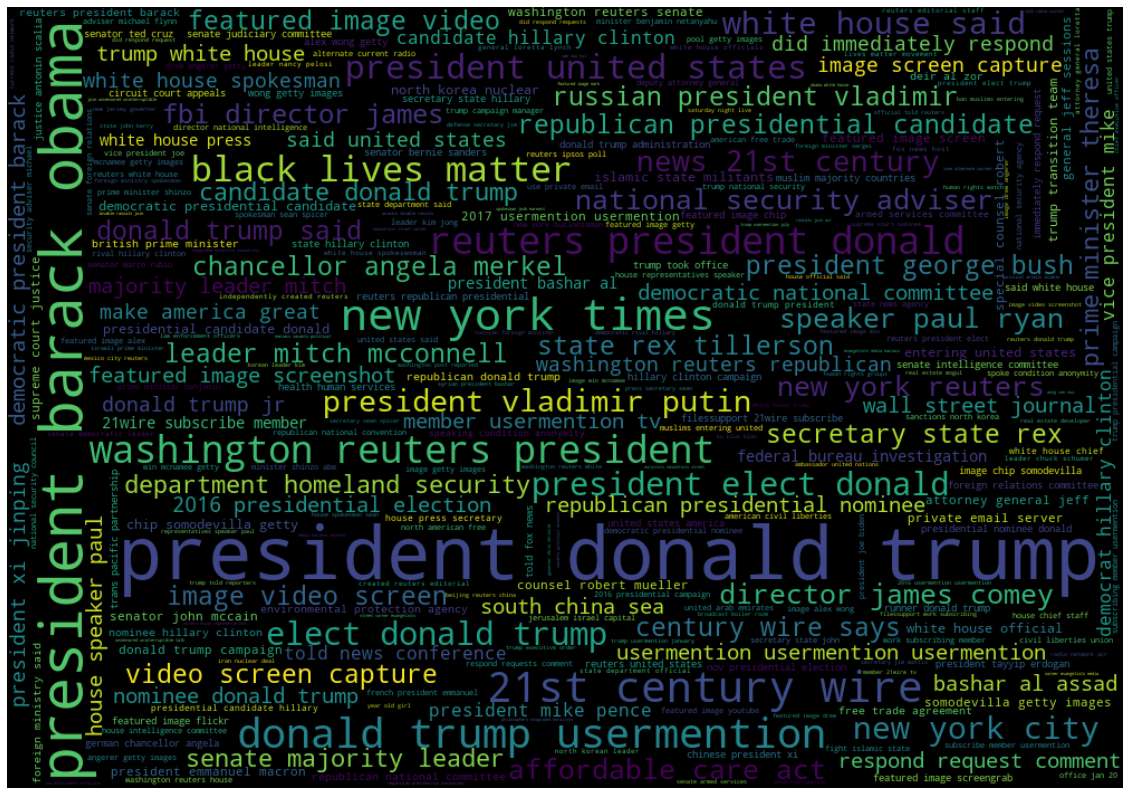

In [94]:
grams_dict = dict(zip(freq_matrix['term'].tolist(), freq_matrix['tf'].tolist()))
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=700, max_words=300).generate_from_frequencies(grams_dict)
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [83]:
number_of_terms = 40
# store term resulting from sorting based on frequencies
selected_terms = freq_matrix.sort_values(['tf'], ascending = False)[:20].sort_values(['idf'], ascending = False)[:number_of_terms][['term','tf','idf']]
search_values = list(freq_matrix.sort_values(['tf'], ascending = False)[:20].sort_values(['idf'], ascending = False)[:number_of_terms]['term'])

# split every x-gram into a list of words
search_values_splitted = [xgram.split() for xgram in search_values]
selected_terms

,term,tf,idf
25,affordable care act,905,5.181293
55,black lives matter,1356,5.104170
388,national security adviser,900,5.098787
135,director james comey,875,5.036348
401,new york city,1036,5.000430
631,speaker paul ryan,854,4.979960
762,white house said,1056,4.931113
409,news 21st century,943,4.885626
469,president vladimir putin,982,4.840043
150,donald trump realdonaldtrump,1790,4.737692


In [84]:
search_values

['affordable care act',
 'black lives matter',
 'national security adviser',
 'director james comey',
 'new york city',
 'speaker paul ryan',
 'white house said',
 'news 21st century',
 'president vladimir putin',
 'donald trump realdonaldtrump',
 'president united states',
 'president elect donald',
 'elect donald trump',
 '21st century wire',
 'new york times',
 'washington reuters president',
 'reuters president donald',
 'pic twitter com',
 'president barack obama',
 'president donald trump']

In [85]:
warnings.simplefilter(action='ignore')
# search spin words into the original dataset and tag them with the corresponding x-gram accordingly
corpus_data_search = pd.DataFrame()
corpus_data_search = searchGrams(docs_all, search_values)
print(corpus_data_search.shape)

Searching x-gram affordable care act found 67
Searching x-gram black lives matter found 130
Searching x-gram national security adviser found 765
Searching x-gram director james comey found 0
Searching x-gram new york city found 2
Searching x-gram speaker paul ryan found 0
Searching x-gram white house said found 120
Searching x-gram news 21st century found 38
Searching x-gram president vladimir putin found 0
Searching x-gram donald trump realdonaldtrump found 6
Searching x-gram president united states found 15
Searching x-gram president elect donald found 10
Searching x-gram elect donald trump found 18
Searching x-gram 21st century wire found 9
Searching x-gram new york times found 0
Searching x-gram washington reuters president found 0
Searching x-gram reuters president donald found 0
Searching x-gram pic twitter com found 3504
Searching x-gram president barack obama found 0
Searching x-gram president donald trump found 28
(4712, 6)


## Classification

In [95]:
import torch
from torchtext.datasets import AG_NEWS
train_iter = iter(AG_NEWS(split='train'))

ModuleNotFoundError: No module named 'torchtext'